In [2]:
import pyart
from scipy.stats import mstats
import numpy.ma as ma
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeat
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import pandas as pd
import numpy as np
import cartopy.geodesic as cargeo
from shapely.geometry import Polygon
import warnings
warnings.filterwarnings('ignore')

In [3]:
file_name="PHA210812102004(testcases).RAWKYLY"
radar = pyart.io.read_sigmet(file_name)
lat_0 = radar.latitude['data'][0]
lon_0 = radar.longitude['data'][0]
shape_grid = (7, 201,201)

In [6]:
radar.fields['differential_reflectivity']

{'units': 'dB',
 'standard_name': 'log_differential_reflectivity_hv',
 'long_name': 'Differential reflectivity',
 'coordinates': 'elevation azimuth range',
 'data': masked_array(
   data=[[0.9599999785423279, 2.4000000953674316, 2.119999885559082, ...,
          --, --, --],
         [-0.05999999865889549, -2.680000066757202, -0.6600000262260437,
          ..., --, --, --],
         [-1.399999976158142, 4.389999866485596, 5.210000038146973, ...,
          --, --, --],
         ...,
         [-0.9200000166893005, 4.429999828338623, 4.269999980926514, ...,
          --, --, --],
         [--, 6.849999904632568, 5.550000190734863, ..., --, --, --],
         [-1.4800000190734863, 1.5, 6.510000228881836, ..., --, --, --]],
   mask=[[False, False, False, ...,  True,  True,  True],
         [False, False, False, ...,  True,  True,  True],
         [False, False, False, ...,  True,  True,  True],
         ...,
         [False, False, False, ...,  True,  True,  True],
         [ True, False, Fa

In [3]:
class UF:
    def __init__(self,radar,shape_grid,lat_0, lon_0):
        self.radar = radar
        self.shape = shape_grid
        self.lat_0 = lat_0
        self.lon_0 = lon_0
    def noise_rejection(self):
        #reject noise radar
        range_bins=self.radar.range['data']
        ref_last_bins=self.radar.fields['reflectivity']['data'][:,-5:]
        Z_f=mstats.mode(ref_last_bins,axis=None)[0][0]
        Z_s=pyart.retrieve.compute_noisedBZ(1800, noisedBZ_val=Z_f, _range=range_bins, ref_dist=300., noise_field='noise_dbz')
        Z_splus4=Z_s['data']+4
        conditions_masked=ma.masked_less(self.radar.fields['reflectivity']['data'],Z_splus4)
        #mask Z<0
        self.radar.add_field_like('reflectivity', 'reflectivity_cor_noise',ma.masked_less_equal(conditions_masked,0.),replace_existing=True) 
        #self.radar.add_field_like('reflectivity', 'reflectivity_cor_noise',conditions_masked,replace_existing=True)
    def convert_grid(self):
        grid = pyart.map.grid_from_radars(
            self.radar,
            grid_shape=self.shape, #Number of points in the grid (z, y, x)
            grid_limits=((0, 9000), (-200000, 200000), (-200000, 200000)), # min-max tuong duong z,y,x
            grid_origin = (self.lat_0, self.lon_0),
            fields=['reflectivity_cor_noise'],
            roi_func='dist_beam',
            weighting_function='cressman')
        return grid
    def convert_lat_lon(self, grid):
        #conver distance to lat/lon
        for i in range(self.shape[1]):
            geog = pyart.core.cartesian_to_geographic_aeqd(grid.x["data"][i],grid.y["data"][i],self.lon_0, self.lat_0, R=6370997.0)
            grid.x["data"][i] = geog[0]
            grid.y["data"][i] = geog[1]
        return grid

In [4]:
UF_File = UF(radar, shape_grid, lat_0, lon_0)
ref_cor_noise=UF_File.noise_rejection()
grid = UF_File.convert_grid()
grid_lat_lon = UF_File.convert_lat_lon(grid)

In [5]:
# Draw Range_Rings
circle_points_50km= cargeo.Geodesic().circle(lon=103.526,lat=21.5632, radius=50000, n_samples=180, endpoint=False)
circle_points_100km= cargeo.Geodesic().circle(lon=103.526,lat=21.5632, radius=100000, n_samples=180, endpoint=False)
circle_points_200km= cargeo.Geodesic().circle(lon=103.526,lat=21.5632, radius=200000, n_samples=180, endpoint=False)
geom_50km=Polygon(circle_points_50km)
geom_100km=Polygon(circle_points_100km)
geom_200km=Polygon(circle_points_200km)

In [6]:
lon=grid_lat_lon.x['data']
lat=grid_lat_lon.y['data']
lons,lats=np.meshgrid(lon,lat)
pre=grid.fields['reflectivity_cor_noise']['data'][1,:,:]

TypeError: colorbar() missing 1 required positional argument: 'mappable'

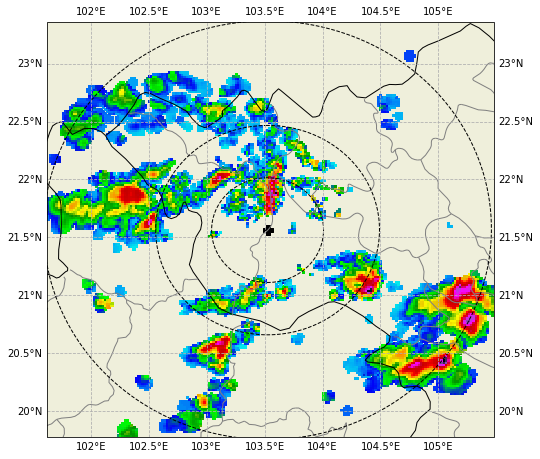

In [14]:
#plot map with datas
fig=plt.figure(figsize=(8,8))
ax=fig.add_subplot(1,1,1, projection=ccrs.PlateCarree())
ax.add_feature(cfeat.LAND)
ax.add_feature(cfeat.OCEAN.with_scale('10m'))
ax.add_feature(cfeat.COASTLINE.with_scale('50m'))
ax.add_feature(cfeat.BORDERS.with_scale('50m'))
state_provinces_lines=cfeat.NaturalEarthFeature(category='cultural',name='admin_1_states_provinces_lines',scale='10m',facecolor='none')
ax.add_feature(state_provinces_lines,edgecolor='gray')
ax.gridlines(draw_labels=True,linestyle='--')
ax.set_extent((grid.x['data'][1],grid.x['data'][-1],grid.y['data'][1],grid.y['data'][-1]),crs=ccrs.PlateCarree())
ax.add_geometries((geom_50km,), crs=ccrs.PlateCarree(), facecolor='none', edgecolor='black', linewidth=1, linestyle='--')
ax.add_geometries((geom_100km,), crs=ccrs.PlateCarree(), facecolor='none', edgecolor='black', linewidth=1, linestyle='--')
ax.add_geometries((geom_200km,), crs=ccrs.PlateCarree(), facecolor='none', edgecolor='black', linewidth=1, linestyle='--')
ax.pcolormesh(lons,lats,pre,shading='flat',cmap=pyart.graph.cm.NWSRef)
ax.scatter(x=103.526,y=21.5632,transform=ccrs.PlateCarree(), color="black",s=100, alpha=1,marker='P')
fig.colorbar()

AttributeError: 'Radar' object has no attribute 'to_xarray'

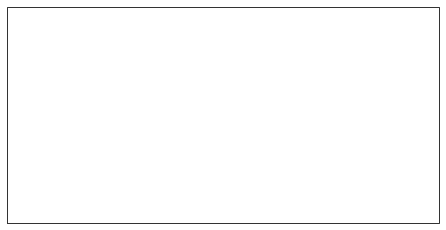

In [17]:
display = pyart.graph.GridMapDisplay(radar)
projection = ccrs.PlateCarree()

fig = plt.figure(figsize=[15, 7])

map_panel_axes = [0.05, 0.05, .4, .80]
x_cut_panel_axes = [0.55, 0.10, .4, .25]
y_cut_panel_axes = [0.55, 0.50, .4, .25]

# Set parameters.
level = 1
vmin = -8
vmax = 64
lat = 36.5
lon = -97.7

# Panel 1: PPI plot of the second tilt.
ax1 = fig.add_axes(map_panel_axes, projection=projection)
display.plot_grid('REF', 1, vmin=vmin, vmax=vmax,
                  projection=projection,
                  cmap='pyart_HomeyerRainbow')
display.plot_crosshairs(lon=lon, lat=lat)

# Panel 2: longitude slice
ax2 = fig.add_axes(x_cut_panel_axes)
display.plot_longitude_slice('REF', lon=lon, lat=lat,
                             vmin=vmin, vmax=vmax)
                             #cmap='pyart_HomeyerRainbow')

ax2.set_ylim([0, 15])
ax2.set_xlim([-50, 50])

# Panel 3: latitude slice
ax3 = fig.add_axes(y_cut_panel_axes)
display.plot_latitude_slice('REF', lon=lon, lat=lat,
                            vmin=vmin, vmax=vmax,
                            cmap='pyart_HomeyerRainbow')
ax3.set_ylim([0, 15])
ax3.set_xlim([-50, 50])

plt.show()